In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

## __1 - Business Problem__  
___Forecast the airlines data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting___  

## __2 - Data collection and description__ 

In [3]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("Airlines+Data.csv")

Saving Airlines+Data.csv to Airlines+Data.csv


In [5]:
df1 = df.copy()

In [6]:
df1.head()

,Month,Passengers
0,Jan-95,112
1,Feb-95,118
2,Mar-95,132
3,Apr-95,129
4,May-95,121


In [7]:
df1.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [8]:
df1.dtypes

Month         object
Passengers     int64
dtype: object

In [9]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,96.0,213.708333,71.918216,104.0,156.0,200.0,264.75,413.0


In [10]:
df1 = df1.set_index('Month')

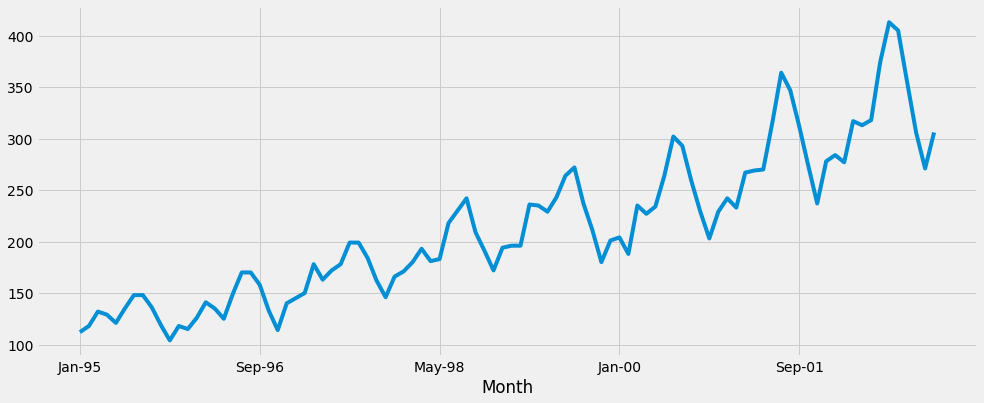

In [11]:
df1['Passengers'].plot(figsize=(15, 6))
plt.show()

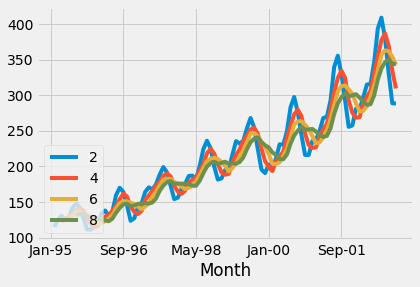

In [12]:
for i in range(2,10,2):
    df1['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

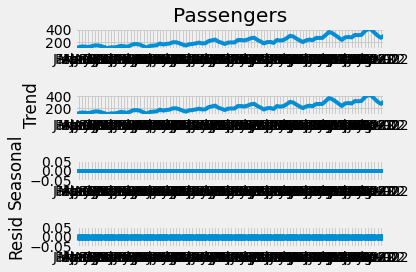

In [21]:
ts_add = seasonal_decompose(df1['Passengers'],period=1,model="additive")
fig = ts_add.plot()
plt.show()

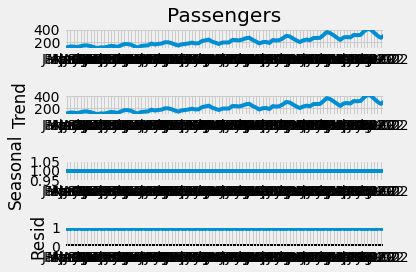

In [23]:
ts_mul = seasonal_decompose(df1.Passengers,period=1,model="multiplicative")
fig = ts_mul.plot()
plt.show()

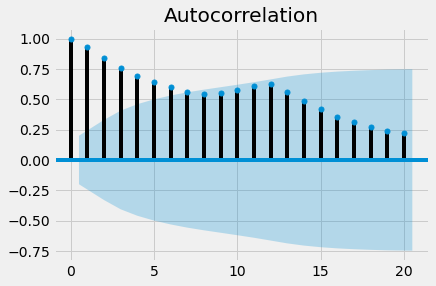

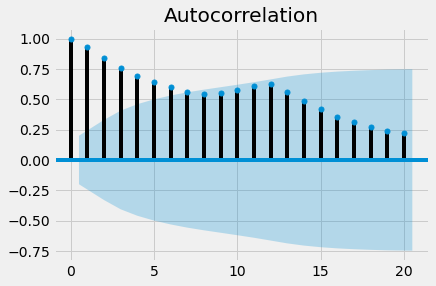

In [24]:
tsa_plots.plot_acf(df1['Passengers'])

## __3 - Building Time series forecasting with ARIMA__ 

In [26]:
X = df1['Passengers'].values

In [27]:
size = int(len(X) * 0.66)

In [28]:
train, test = X[0:size], X[size:len(X)]

In [29]:
model = ARIMA(train, order=(5,1,0))

In [30]:
model_fit = model.fit(disp=0)

In [31]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   62
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -262.909
Method:                       css-mle   S.D. of innovations             16.748
Date:                Tue, 27 Dec 2022   AIC                            539.817
Time:                        10:25:14   BIC                            554.707
Sample:                             1   HQIC                           545.663
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7497      1.477      1.185      0.236      -1.145       4.644
ar.L1.D.y      0.0905      0.134      0.677      0.498      -0.171       0.352
ar.L2.D.y     -0.2096      0.135     -1.549      0.1

### This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations

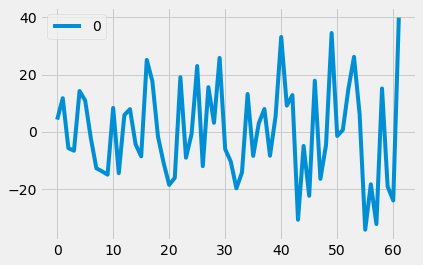

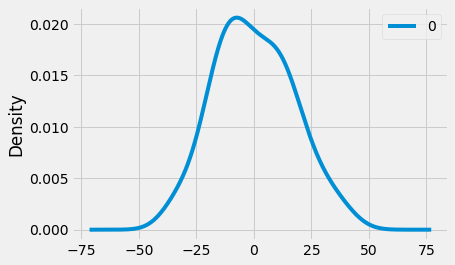

               0
count  62.000000
mean    0.057351
std    16.895802
min   -34.303300
25%   -12.610654
50%    -1.589480
75%    12.565603
max    39.955354


In [32]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

### The plot of the residual errors suggests that there may still be some trend information not captured by the model  
### The results show that there is no a bias in the prediction (a zero mean in the residuals)  

### __3.1 - Rolling Forecast ARIMA Model__ 

In [33]:
history = [x for x in train]

In [34]:
predictions = list()

In [35]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=239.755201, expected=227.000000
predicted=220.737320, expected=234.000000
predicted=237.815016, expected=264.000000
predicted=252.750595, expected=302.000000
predicted=306.715968, expected=293.000000
predicted=285.374658, expected=259.000000
predicted=250.264002, expected=229.000000
predicted=227.093128, expected=203.000000
predicted=211.011438, expected=229.000000
predicted=253.260263, expected=242.000000
predicted=252.490668, expected=233.000000
predicted=234.042130, expected=267.000000
predicted=268.773623, expected=269.000000
predicted=261.782249, expected=270.000000
predicted=271.798044, expected=315.000000
predicted=314.422112, expected=364.000000
predicted=368.637707, expected=347.000000
predicted=334.957876, expected=312.000000
predicted=301.161837, expected=274.000000
predicted=265.936490, expected=237.000000
predicted=244.037204, expected=278.000000
predicted=312.961762, expected=284.000000
predicted=291.748169, expected=277.000000
predicted=284.551896, expected=317

In [36]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 782.495


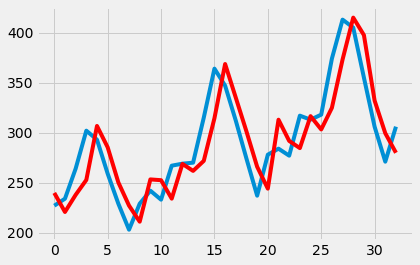

In [37]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale  

## __4 - Comparing Multiple Models__ 

In [38]:
df2 = df.copy()

In [39]:
df2 = pd.get_dummies(df2, columns = ['Month'])

In [40]:
df2.head()

,Passengers,Month_Apr-00,Month_Apr-01,Month_Apr-02,Month_Apr-95,Month_Apr-96,Month_Apr-97,Month_Apr-98,Month_Apr-99,Month_Aug-00,...,Month_Oct-98,Month_Oct-99,Month_Sep-00,Month_Sep-01,Month_Sep-02,Month_Sep-95,Month_Sep-96,Month_Sep-97,Month_Sep-98,Month_Sep-99
0,112,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,118,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,132,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,129,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df2.shape

(96, 97)

In [42]:
t= np.arange(1,97)

In [43]:
df2['t'] = t

In [44]:
df2['t_sq'] = df2['t']*df2['t']

In [45]:
log_Passengers=np.log(df2['Passengers'])

In [46]:
df2['log_Passengers']=log_Passengers

In [47]:
df2.head()

,Passengers,Month_Apr-00,Month_Apr-01,Month_Apr-02,Month_Apr-95,Month_Apr-96,Month_Apr-97,Month_Apr-98,Month_Apr-99,Month_Aug-00,...,Month_Sep-01,Month_Sep-02,Month_Sep-95,Month_Sep-96,Month_Sep-97,Month_Sep-98,Month_Sep-99,t,t_sq,log_Passengers
0,112,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,4.718499
1,118,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,4,4.770685
2,132,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,9,4.882802
3,129,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,4,16,4.859812
4,121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,25,4.795791


In [48]:
train1, test1 = np.split(df2, [int(.67 *len(df2))])

In [49]:
linear= smf.ols('Passengers ~ t',data=train1).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test1['t'])))
rmselin=np.sqrt((np.mean(np.array(test1['Passengers'])-np.array(predlin))**2))
rmselin

25.50398351648347

In [50]:
quad=smf.ols('Passengers~t+t_sq',data=train1).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test1[['t','t_sq']])))
rmsequad=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(predquad))**2))
rmsequad

53.189555144151804

In [51]:
expo=smf.ols('Passengers~t',data=train1).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test1['t'])))
rmseexpo=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(np.exp(predexp)))**2))
rmseexpo

1.6030945933279498e+128

### linear=25.503, Quad=53.189, Expo=1.603
Multiplicative seasonality with linear trend has the best RMSE value